In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, DenseNet121, Xception, MobileNetV2, EfficientNetB0, NASNetMobile, InceptionResNetV2, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Average
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

# Global variables
max_images_per_breed = 100
total_epochs = 2  
num_of_threads = 32
batch_size = 64

# Set the number of threads for TensorFlow
os.environ["OMP_NUM_THREADS"] = str(num_of_threads)
os.environ["TF_NUM_INTRAOP_THREADS"] = str(num_of_threads)
os.environ["TF_NUM_INTEROP_THREADS"] = str(num_of_threads)

# Enable XLA for possible speed improvements
tf.config.optimizer.set_jit(True)  # Enable XLA (Accelerated Linear Algebra)

# Set directories
base_dir = os.getcwd()
thesis_dir = os.path.abspath(os.path.join(base_dir, ".."))
models_dir = os.path.join(thesis_dir, 'models')
class_indices_path = os.path.join(thesis_dir, 'class_indices.json')
train_dir = os.path.join(thesis_dir, 'images', 'train')
val_dir = os.path.join(thesis_dir, 'images', 'val')

def create_model(model_type, num_classes):
    if model_type == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'resnet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'inceptionv3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'densenet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'xception':
        base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'mobilenetv2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'efficientnetb0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'nasnetmobile':
        base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'inceptionresnetv2':
        base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'vgg19':
        base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    
    return model

def load_image_paths_and_labels(directory, max_images_per_breed):
    image_paths = []
    labels = []
    for breed in os.listdir(directory):
        breed_path = os.path.join(directory, breed)
        if os.path.isdir(breed_path):
            breed_images = os.listdir(breed_path)[:max_images_per_breed]
            for image_name in breed_images:
                image_paths.append(os.path.join(breed_path, image_name))
                labels.append(breed)
    return image_paths, labels

def train(model_types=['vgg16', 'resnet50', 'inceptionv3']):
    if not os.path.exists(train_dir):
        raise FileNotFoundError(f"Training directory not found: {train_dir}")
    if not os.path.exists(val_dir):
        raise FileNotFoundError(f"Validation directory not found: {val_dir}")
    
    train_image_paths, train_labels = load_image_paths_and_labels(train_dir, max_images_per_breed)
    val_image_paths, val_labels = load_image_paths_and_labels(val_dir, max_images_per_breed)
    
    train_df = pd.DataFrame({'filename': train_image_paths, 'class': train_labels})
    val_df = pd.DataFrame({'filename': val_image_paths, 'class': val_labels})
    
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_dataframe(
        train_df, x_col='filename', y_col='class', target_size=(224, 224), class_mode='categorical', batch_size=batch_size)

    val_generator = val_datagen.flow_from_dataframe(
        val_df, x_col='filename', y_col='class', target_size=(224, 224), class_mode='categorical', batch_size=batch_size)

    num_classes = len(train_generator.class_indices)
    
    with open(class_indices_path, 'w') as f:
        json.dump(train_generator.class_indices, f)
    
    models = []
    for model_type in model_types:
        print(f"Creating and training new model: {model_type}")
        model = create_model(model_type, num_classes)
        model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
        early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=total_epochs,
            callbacks=[early_stopping]
        )
        
        # Save the trained model
        model_file = os.path.join(models_dir, f'{model_type}.h5')
        model.save(model_file, save_format='h5')
        print(f"Model saved to: {model_file}")

        models.append(model)
    
    # Create an ensemble model
    inputs = tf.keras.Input(shape=(224, 224, 3))
    outputs = [model(inputs) for model in models]
    avg_output = Average()(outputs)
    ensemble_model = Model(inputs=inputs, outputs=avg_output)
    ensemble_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
    
    # Train the ensemble model
    history = ensemble_model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=total_epochs,
        callbacks=[early_stopping]
    )
    
    # Save the ensemble model with model names
    ensemble_model_filename = os.path.join(models_dir, '_'.join(model_types) + '_ensemble.h5')
    ensemble_model.save(ensemble_model_filename, save_format='h5')
    print(f"Ensemble model saved to: {ensemble_model_filename}")
    
    # Plot training and validation accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))
    
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.show()
    
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


Found 7300 validated image filenames belonging to 73 classes.
Found 2606 validated image filenames belonging to 73 classes.
Creating and training new model: nasnetmobile
Epoch 1/2


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


115/115 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.5249 - loss: 2.1748 - val_accuracy: 0.8910 - val_loss: 0.3766
Epoch 2/2
115/115 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.7946 - loss: 0.8008 - val_accuracy: 0.8998 - val_loss: 0.3790


Model saved to: C:\Users\josej\Thesis\models\nasnetmobile.h5
Creating and training new model: inceptionv3
Epoch 1/2
115/115 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.4692 - loss: 2.5227 - val_accuracy: 0.8557 - val_loss: 0.5485
Epoch 2/2
115/115 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.7587 - loss: 1.0078 - val_accuracy: 0.8711 - val_loss: 0.4894


Model saved to: C:\Users\josej\Thesis\models\inceptionv3.h5
Creating and training new model: xception
Epoch 1/2
115/115 ━━━━━━━━━━━━━━━━━━━━ 378s 3s/step - accuracy: 0.5503 - loss: 1.9265 - val_accuracy: 0.8603 - val_loss: 0.5121
Epoch 2/2
115/115 ━━━━━━━━━━━━━━━━━━━━ 372s 3s/step - accuracy: 0.7843 - loss: 0.8435 - val_accuracy: 0.8584 - val_loss: 0.5840


Model saved to: C:\Users\josej\Thesis\models\xception.h5
Epoch 1/2
115/115 ━━━━━━━━━━━━━━━━━━━━ 609s 5s/step - accuracy: 0.8372 - loss: 0.0000e+00 - val_accuracy: 0.9252 - val_loss: 0.0000e+00
Epoch 2/2
115/115 ━━━━━━━━━━━━━━━━━━━━ 575s 5s/step - accuracy: 0.8512 - loss: 0.0000e+00 - val_accuracy: 0.9175 - val_loss: 0.0000e+00


Ensemble model saved to: C:\Users\josej\Thesis\models\nasnetmobile_inceptionv3_xception_ensemble.h5


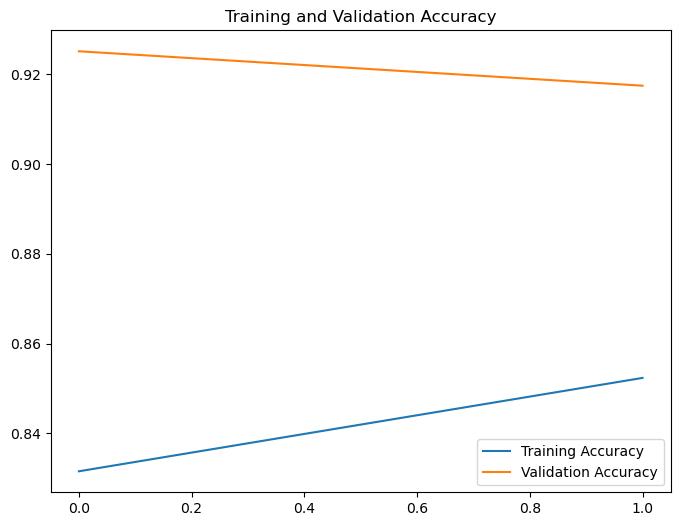

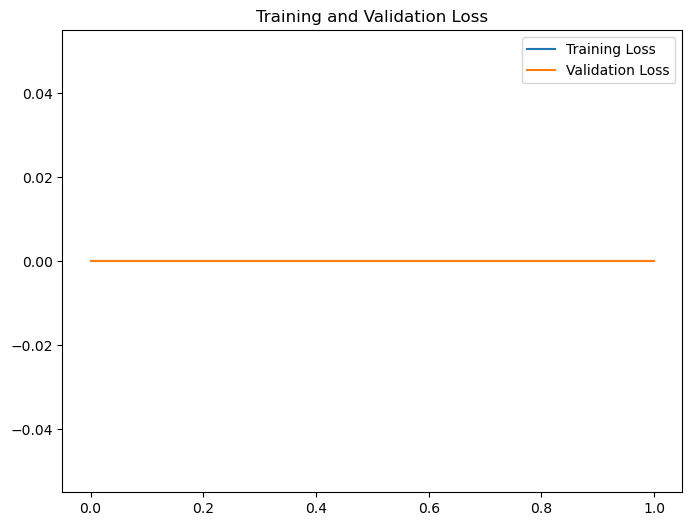

"\ntrain(['mobilenetv2', 'densenet121', 'inceptionv3'])\ntrain(['xception', 'densenet121', 'nasnetmobile'])\ntrain(['inceptionv3', 'mobilenetv2', 'xception'])\ntrain(['densenet121', 'nasnetmobile', 'mobilenetv2'])\ntrain(['inceptionv3', 'densenet121', 'xception'])\ntrain(['mobilenetv2', 'xception', 'nasnetmobile'])\ntrain(['nasnetmobile', 'densenet121', 'inceptionv3'])\ntrain(['xception', 'mobilenetv2', 'densenet121'])\ntrain(['nasnetmobile', 'mobilenetv2', 'inceptionv3'])\n"

In [2]:
train(['nasnetmobile', 'inceptionv3', 'xception'])

'''
train(['mobilenetv2', 'densenet121', 'inceptionv3'])
train(['xception', 'densenet121', 'nasnetmobile'])
train(['inceptionv3', 'mobilenetv2', 'xception'])
train(['densenet121', 'nasnetmobile', 'mobilenetv2'])
train(['inceptionv3', 'densenet121', 'xception'])
train(['mobilenetv2', 'xception', 'nasnetmobile'])
train(['nasnetmobile', 'densenet121', 'inceptionv3'])
train(['xception', 'mobilenetv2', 'densenet121'])
train(['nasnetmobile', 'mobilenetv2', 'inceptionv3'])
'''
